In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def conv(s):
    if s == '':
        return np.nan
    return np.float64(s.replace(',', '.'))

In [4]:
train_data = pd.read_csv('./init/1/train_1.8.csv', encoding='cp1251', converters={'Нефть, т' : conv,
                                                                           'Попутный газ, м3' : conv,
                                                                           'Нефть, м3' : conv,
                                                                           'Время работы, ч' : conv})
test_data = pd.read_csv('./init/1/test_1.9.csv', encoding='cp1251')

In [5]:
train_wells = np.unique(train_data[train_data['Характер работы'] == 'НЕФ']['Скважина'])
test_wells = np.unique(test_data['Скважина'])

In [6]:
feats = ['Скважина', 'Характер работы', 'Дата', 'Нефть, т', 'Попутный газ, м3', 'Время работы, ч', 'Нефть, м3', 'Дебит жидкости', 'Обводненность']

In [7]:
new_df = []

for well in train_wells:
    cur_df = train_data[train_data['Скважина'] == well][feats].sort_values('Дата')
    if cur_df['Нефть, т'].iloc[0] != '0.00':
        cur_df = cur_df.iloc[0]
    elif cur_df['Нефть, т'].iloc[1] != '0.00':
        cur_df = cur_df.iloc[1]
    elif cur_df['Нефть, т'].iloc[2] != '0.00':
        cur_df = cur_df.iloc[2]
    elif cur_df['Нефть, т'].iloc[3] != '0.00':
        cur_df = cur_df.iloc[3]
    else:
        cur_df = cur_df.iloc[4]
    
    new_df.append(cur_df)

In [8]:
new_df = pd.concat(new_df, axis=1).T

In [9]:
new_df['Дебит'] = new_df['Дебит жидкости'] - new_df['Обводненность'] * new_df['Дебит жидкости'] / 100

In [10]:
new_df['Дебит2'] = new_df['Нефть, м3'] / (new_df['Время работы, ч'] / 24)

In [11]:
new_df['Дебит'] = new_df['Дебит'].fillna(new_df['Дебит2'])

In [12]:
debit_train = new_df[['Скважина', 'Нефть, т', 'Время работы, ч', 'Дебит', 'Попутный газ, м3']].dropna(0)

In [13]:
debit_train.head()

,Скважина,"Нефть, т","Время работы, ч",Дебит,"Попутный газ, м3"
1570,005642f48d3e86d871bb701bac2ba042,462,432,29.722222,29568
768,02bd0350b7f0cef7af7ca50801d89810,15.32,24,18.270000,2148
1600,038753062b1b3941bbce024a2af27e18,553,216,71.111111,35392
1816,04154a658a396d1c18331ebf0330744f,46,80,15.600000,3166
42,04d7884a9f7019671285b87ca468d0f1,334,310,29.729032,11718


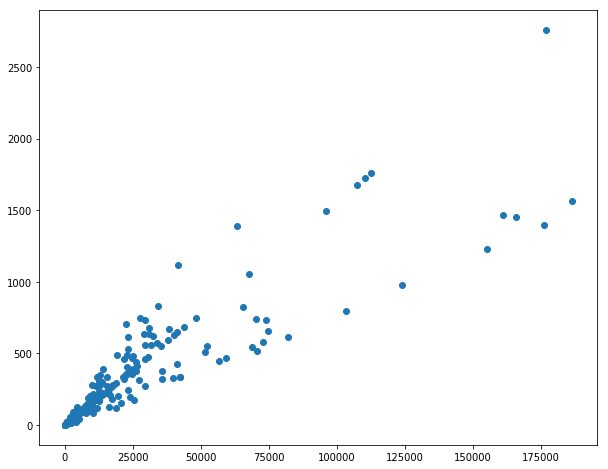

In [14]:
x = debit_train['Попутный газ, м3'].values.astype(np.float64)[:, np.newaxis]
y = debit_train['Нефть, т'].values.astype(np.float64)[:, np.newaxis]
angle = y / (x + 1)

plt.figure(figsize=(10, 8))
plt.scatter(x, y)
#plt.xlim(0, 300000)

In [15]:
xy = angle #np.hstack([x, y, angle])

In [16]:
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN

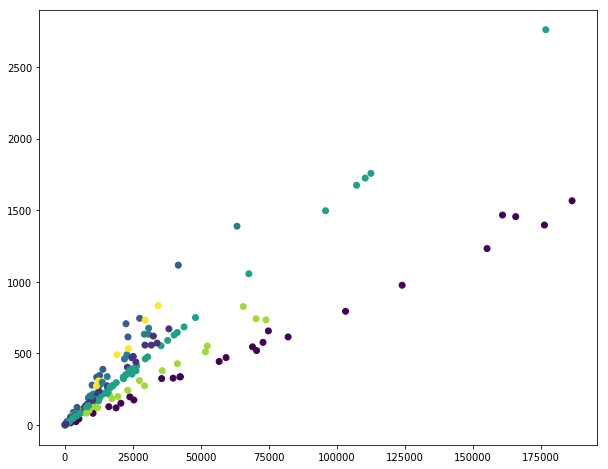

In [17]:
kmeans = KMeans(n_clusters = 8, random_state=1543)


labels = kmeans.fit_predict(xy)[:, None]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=labels)

In [18]:
z = debit_train['Время работы, ч'].values.astype(np.float64)[:, np.newaxis]

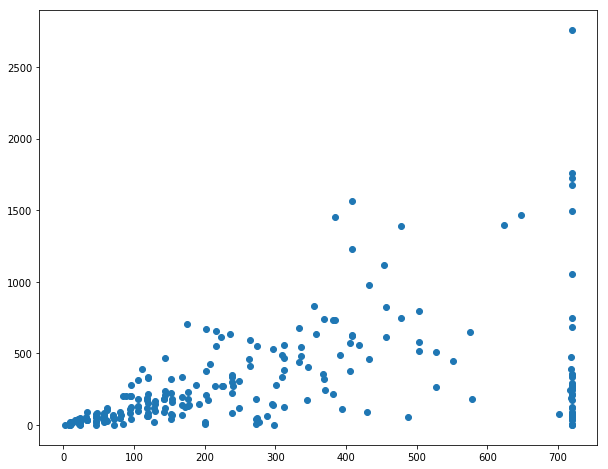

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(z, y)

## Достанем данные по координатам

In [20]:
coords_train = pd.read_csv('./init/1/coords_train_1.1.csv', encoding='cp1251')
coords_train = coords_train.groupby('well_hash')['ПЛАСТ_X', 'ПЛАСТ_Y'].mean()
coords_train.reset_index(inplace=True)
coords_train.rename(columns={'well_hash' : 'Скважина'}, inplace=True)

In [21]:
coords_test = pd.read_csv('./init/1/coords_test_1.1.csv', encoding='cp1251')
coords_test = coords_test.groupby('well_hash')['ПЛАСТ_X', 'ПЛАСТ_Y'].mean()
coords_test.reset_index(inplace=True)
coords_test.rename(columns={'well_hash' : 'Скважина'}, inplace=True)

In [22]:
coords_train.head()

,Скважина,ПЛАСТ_X,ПЛАСТ_Y
0,02bd0350b7f0cef7af7ca50801d89810,1.297986e+07,3.998130e+07
1,046568c4bd1c6343c5f932ef6a21b112,1.243139e+07,3.780028e+07
2,04d7884a9f7019671285b87ca468d0f1,1.243339e+07,3.781346e+07
3,053c7b37c95c4617f331791134227db7,1.240853e+07,3.776296e+07
4,0556368a803a0c64972646d4bfaecd86,1.164759e+07,3.637853e+07


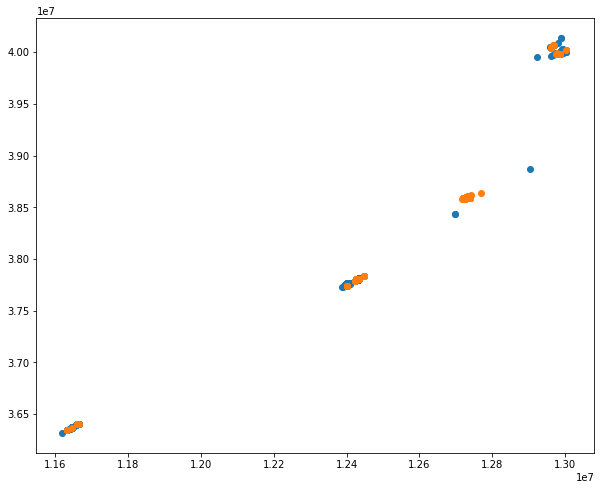

In [23]:
x_train = coords_train['ПЛАСТ_X'].values
y_train = coords_train['ПЛАСТ_Y'].values

x_test = coords_test['ПЛАСТ_X'].values
y_test = coords_test['ПЛАСТ_Y'].values

plt.figure(figsize=(10, 8))
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

## Достанем данные по давлению в пласте

In [24]:
gdis_train = pd.read_csv('./init/1/gdis_train1.2.csv', encoding='cp1251')
gdis_train = gdis_train.groupby('Скважина').mean().reset_index()

gdis_test = pd.read_csv('./init/1/gdis_test1.2.csv', encoding='cp1251')
gdis_test = gdis_test.groupby('Скважина').mean().reset_index()

In [25]:
gdis_train.head()

,Скважина,Давление пластовое
0,005642f48d3e86d871bb701bac2ba042,103.150000
1,02384c4d1324238fb99fcf66c88fbdad,218.566667
2,02bd0350b7f0cef7af7ca50801d89810,255.150000
3,031f7cf95ada8d6e49ad6bd96c886d9c,83.000000
4,038753062b1b3941bbce024a2af27e18,232.300000


## Достанем данные по ГРП

In [26]:
grp_df_train = pd.read_csv('./init/1/frac_train_1.csv', encoding='cp1251')

In [27]:
grp_train = pd.Series(train_wells).apply(lambda x: x in grp_df_train['Скважина'].values).astype(int)

In [28]:
grp_train = pd.DataFrame(data=np.stack([train_wells, grp_train], axis=1), columns=['Скважина', 'ГРП'])

In [29]:
grp_train.head()

,Скважина,ГРП
0,005642f48d3e86d871bb701bac2ba042,1
1,02384c4d1324238fb99fcf66c88fbdad,1
2,02bd0350b7f0cef7af7ca50801d89810,1
3,02dba139f57f4aa50c3fbf56f586551f,1
4,038753062b1b3941bbce024a2af27e18,1


In [30]:
grp_df_test = pd.read_csv('./init/1/frac_test_1.csv', encoding='cp1251')

In [31]:
grp_test = pd.Series(test_wells).apply(lambda x: x in grp_df_test['Скважина'].values).astype(int)

In [32]:
grp_test = pd.DataFrame(data=np.stack([test_wells, grp_test], axis=1), columns=['Скважина', 'ГРП'])

In [33]:
grp_test.head()

,Скважина,ГРП
0,002ff5b8a6dc271f58581e1b4fa2c5fc,1
1,008d0347e572a5d938a9c40c29e539fc,0
2,00b40cb7bb8c9fd1ac26b4cc86f2b291,0
3,01ba18d8b6d29875a18d4bca4eb201d7,1
4,024ec6f6e3f9c5150ecf525bf8b7a6a3,1


## Объединим все!

In [79]:
all_train = pd.concat([debit_train.set_index('Скважина'),
                       grp_train.set_index('Скважина'),
                       gdis_train.set_index('Скважина'),
                       coords_train.set_index('Скважина')], axis=1).dropna(0)

all_test = pd.concat([grp_test.set_index('Скважина'),
                      gdis_test.set_index('Скважина'),
                      coords_test.set_index('Скважина')], axis=1)

In [80]:
all_test['Давление пластовое'].fillna(all_test.mean()['Давление пластовое'], inplace=True)
all_test = all_test.fillna(all_test.mean()[['ПЛАСТ_X', 'ПЛАСТ_Y']])

In [81]:
all_test.head()

,ГРП,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
002ff5b8a6dc271f58581e1b4fa2c5fc,1,178.966195,1.261854e+07,3.839934e+07
008d0347e572a5d938a9c40c29e539fc,0,178.966195,1.272636e+07,3.857880e+07
00b40cb7bb8c9fd1ac26b4cc86f2b291,0,178.966195,1.261854e+07,3.839934e+07
01ba18d8b6d29875a18d4bca4eb201d7,1,117.500000,1.261854e+07,3.839934e+07
024ec6f6e3f9c5150ecf525bf8b7a6a3,1,231.000000,1.243423e+07,3.781085e+07


In [82]:
all_train.head()

,"Нефть, т","Время работы, ч",Дебит,"Попутный газ, м3",ГРП,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y
02bd0350b7f0cef7af7ca50801d89810,15.32,24,18.270000,2148,1,255.150000,1.297986e+07,3.998130e+07
04d7884a9f7019671285b87ca468d0f1,334,310,29.729032,11718,1,232.000000,1.243339e+07,3.781346e+07
053c7b37c95c4617f331791134227db7,11,9,32.000000,462,1,148.333333,1.240853e+07,3.776296e+07
0556368a803a0c64972646d4bfaecd86,1396,624,65.076923,176348,1,120.000000,1.164759e+07,3.637853e+07
0a0106327ac0b21fe3033dc746605ecb,128,96,39.000000,16189,1,162.133333,1.163249e+07,3.634854e+07


## Научимся кластеризовать

Обучающая выборка

In [83]:
X = all_train[['ГРП', 'Давление пластовое', 'ПЛАСТ_X', 'ПЛАСТ_Y']].values.astype(np.float64)

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

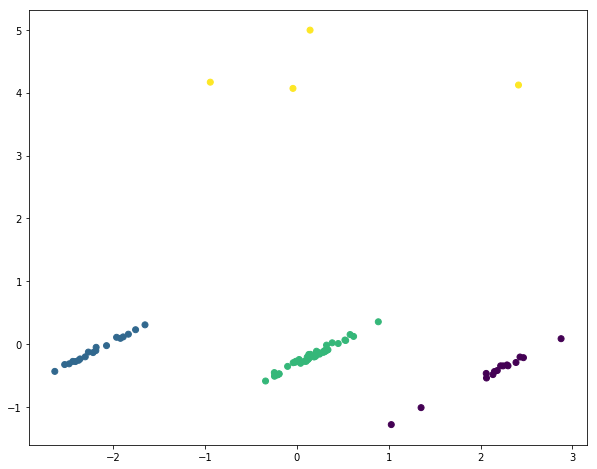

In [86]:
n_clusters = 4
kmeans2 = KMeans(n_clusters=n_clusters, random_state=1543)

train_clusters = kmeans2.fit_predict(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=train_clusters)

Тестовая выборка

In [87]:
Y = all_test.values.astype(np.float64)

In [88]:
Y_scaled = scaler.transform(Y)

In [89]:
Y_2d = pca.transform(Y_scaled)

In [90]:
test_clusters = kmeans2.predict(Y_scaled)

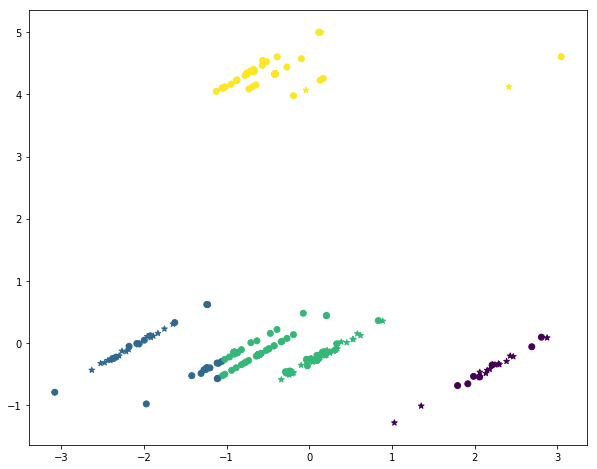

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(Y_2d[:, 0], Y_2d[:, 1], c=test_clusters)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=train_clusters, marker='*')

In [92]:
all_train['cluster'] = train_clusters
all_test['cluster'] = test_clusters

In [93]:
mean_oil_for_clusters = dict(all_train.astype(np.float64).groupby('cluster').mean()['Нефть, т'])
mean_debit_for_clusters = dict(all_train.astype(np.float64).groupby('cluster').mean()['Дебит'])

In [94]:
all_test['stating oil prediction'] = list(map(lambda x : mean_oil_for_clusters[x], test_clusters))
all_test['stating debit prediction'] = list(map(lambda x : mean_debit_for_clusters[x], test_clusters))

In [95]:
all_test.head()

,ГРП,Давление пластовое,ПЛАСТ_X,ПЛАСТ_Y,cluster,stating oil prediction,stating debit prediction
002ff5b8a6dc271f58581e1b4fa2c5fc,1,178.966195,1.261854e+07,3.839934e+07,2,295.932174,42.066527
008d0347e572a5d938a9c40c29e539fc,0,178.966195,1.272636e+07,3.857880e+07,3,348.787500,47.197886
00b40cb7bb8c9fd1ac26b4cc86f2b291,0,178.966195,1.261854e+07,3.839934e+07,3,348.787500,47.197886
01ba18d8b6d29875a18d4bca4eb201d7,1,117.500000,1.261854e+07,3.839934e+07,2,295.932174,42.066527
024ec6f6e3f9c5150ecf525bf8b7a6a3,1,231.000000,1.243423e+07,3.781085e+07,2,295.932174,42.066527


## Кросс-валидация

In [96]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae

In [97]:
X_cv = all_train[['ГРП', 'Давление пластовое', 'ПЛАСТ_X', 'ПЛАСТ_Y']].values.astype(np.float64)
y_cv = all_train['Нефть, т'].values.astype(np.float64)

In [98]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1543)

errors = []

for train_ind, test_ind in kfold.split(X_cv, y_cv):
    X_train = X_cv[train_ind]
    y_train = y_cv[train_ind]
    X_test = X_cv[test_ind]
    y_test = y_cv[test_ind]
    
    scaler_cv = StandardScaler()
    scaler_cv.fit(X_train)
    X_train_scaled = scaler_cv.transform(X_train)
    
    n_clusters = 16
    kmeans_cv = KMeans(n_clusters=n_clusters, random_state=1543)
    train_clusters = kmeans_cv.fit_predict(X_train_scaled)
    train_clusters_df = pd.DataFrame(data=np.stack([train_clusters, y_train], axis=1), columns=['cluster', 'oil'])
    
    X_test_scaled = scaler_cv.transform(X_test)
    test_clusters = kmeans_cv.predict(X_test_scaled)
    test_clusters_df = pd.DataFrame(data=np.stack([test_clusters, y_test], axis=1), columns=['cluster', 'oil'])
    
    
    mean_oil_for_clusters = dict(test_clusters_df.astype(np.float64).groupby('cluster').mean()['oil'])
    predictions = list(map(lambda x : mean_oil_for_clusters[x], test_clusters))
    
    errors.append(mae(y_test, predictions))
    
print(np.mean(errors))

199.89592647058822
